### Pose Estimation Analysis

In [1]:
#     __  __    _                    _           _
#   /|  \/  |  (_)                  (_)         (_)
#  | | \  / |   _  __ ____  __   __  _  _ ____   _   _ ____    _____
#  | | |\/| | /| |/ /  _  \/\ \ / //| |/ / __/ /| | / / _  \ /| '_  \
#  | | |  | || | || | (_) |\ \ V /| | |\ \__ \| | || | (_) || | | | |
#  |_|_|  |_||_|_/ \_\___/  \_\_/ |_|_/|_|___/|_|_/ \_\___/ |_|_/ |_/
#
#  Copyright 2022, Miovision
#  @name    feature_tracking_analysis 
#  @brief   Tracks Features and Visualizes
#  @author  Umer Rasheed

In [2]:
# Import Modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time as time
print('Import Modules!')

Import Modules!


In [3]:
# Set Directory
os.chdir('..')

In [4]:
# Import Local Modules
from utils.metrics import *
from utils.utils import *
from utils.pose_estimation import *

In [5]:
# Read Images from Video
path = 'videos/polaris/morris-lane-nb.mp4'
video, fps, total_frames = load_video(path) 
print("Frame Rate", fps)
print("Total Frames", total_frames)

Frame Rate 7.5
Total Frames 2709


In [6]:
# Set Other Hyperparameters
num_of_frames = 5
max_gap_bw_frames = fps * 2
image_height = 400
image_width = 600
refine_features = False

# Set Parameters for Keyframe Refresher
min_inliers = 25
min_avg_motion = 0.25
max_std_deviation_motion = 10

# Set Parameters for Visualization
plot_flag = True
video_flag = False

In [7]:
# Initialize Feature Extractor
feature_detector = FeatureDetector(mode = "Shi-Tomasi", output = "Corners", verbose = True)
feature_tracker = FeatureTracker()
pose_estimator = PoseEstimator()

Feature Extractor: Shi-Tomasi Output: Corners


In [8]:
# Read First Keyframe 
video.set(1, 0)  
ret, frame = video.read()

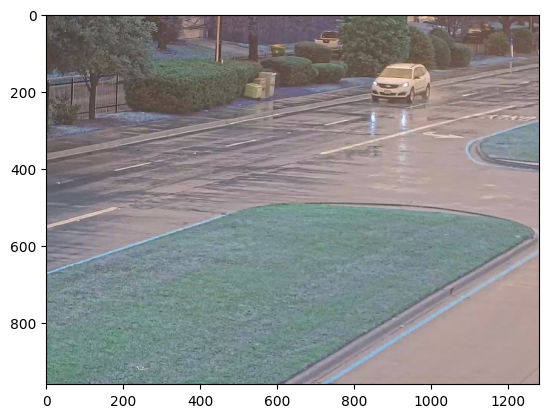

In [9]:
plt.imshow(frame)

In [12]:
# Set Parameters for Video Recording
video_name = 'After.mp4'

# Create Video Recorders
video_before = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 
                               7.5, 
                               (image_width,image_height))

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [13]:
# Set Extreme Transformation
extreme_transformation_matrix = np.array([[ 0.9891916,  0.0124793 , -20.73317932],
                                          [-0.0124793 ,  0.9991916,  60.9093755 ]])

# Set Translation Transformation
translate_transformation_matrix = np.array([[1, 0.0 , -2],
                                          [0.0,  1,  2]])

# Set Translation Transformation
identity_transformation_matrix = np.array([[1, 0.0 , 0],
                                          [0.0,  1,  0]])

# Set Translation Transformation
mild_transformation_matrix = np.array([[ 0.99847858, -0.00201412,  0.30410091],
                                       [0.00201412,  0.99847858, -0.15664118]])

Number of Features 187
Computation Time for Corner Detection (ms) 6.342649459838867
Computation Time for Tracking (ms) 2.3908615112304688
Number of Features Tracked 161
Computation Time for Conversion to Keypoints (ms) 0.4909038543701172
Computation Time for Conversion to Matches (ms) 0.08654594421386719
Computation Time for Pose Estimation (ms) 0.8866786956787109
Number of Inliers: 81
Average Motion of Inliers: 27.26730204215876
Standard Deviation of Inliers: 0.3842221638921764
Transform Quality True


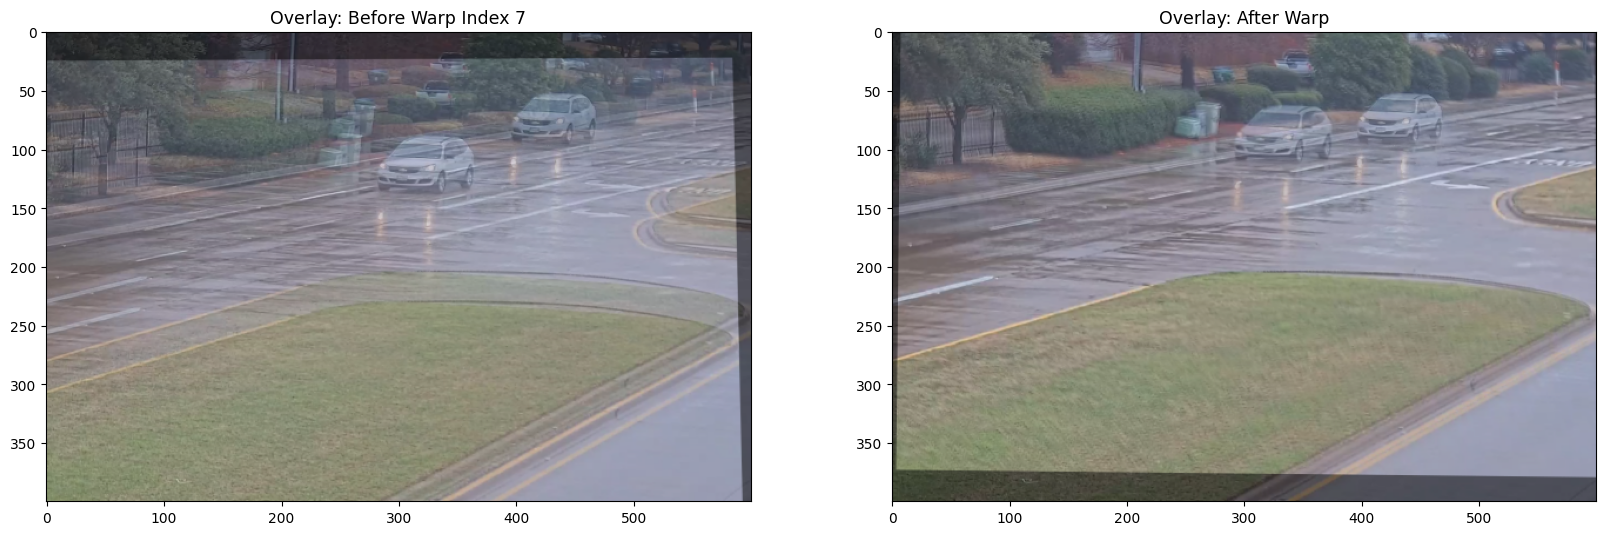

In [21]:
# Read First Keyframe 
video.set(1, 0)  
ret, frame = video.read()
    
# Process Random Images
for i in range(7, total_frames, 50):       
    # Get Current Frame
    video.set(1, i)
    ret, temp_frame = video.read() 
    
    # Preprocess Reference Frame
    img, gray = preprocess_frame(frame, image_width, image_height)
    
    # Add Jitter
    seed = np.random.seed(i)
    jitter = np.array((np.random.rand(2,3)) * 0.01)
    warp_matrix = extreme_transformation_matrix + jitter
    
    # Get Warped Frame
    curr_frame = cv2.warpAffine(temp_frame, warp_matrix, (frame.shape[1], frame.shape[0]))
    
    # Preprocess Current Frame
    curr_img, curr_gray = preprocess_frame(curr_frame, image_width, image_height)
    
    # Extract Features
    corners = feature_detector.extract(gray)
    
    # If Set, Calculate the Refined Corner Locations
    if refine_features:
        corners_refined = feature_detector.refine(gray, corners)
    
    # Track Features via Optical Flow
    corners, curr_corners = feature_tracker.track(gray, curr_gray, corners)
    
    # Convert Keypoints
    kps, curr_kps = feature_tracker.convert_to_tracked_keypoints(corners, curr_corners)
    
    # Get Matches
    matches = feature_tracker.convert_to_matches(corners)
    
    # Filter Matches with GMS
    feature_tracker.apply_GMS(img, curr_img, kps, curr_kps, matches)
    
    # Get Corners
    corners_filtered, curr_corners_filtered = feature_tracker.convert_to_tracked_corners(matches_gms, 
                                                                                         kps, 
                                                                                         curr_kps)
    
    # Estimation Pose
    transformation_rigid_matrix, inlier_mask = pose_estimator.compute_pose(np.array(corners_filtered), 
                                                                           np.array(curr_corners_filtered))
    
    # Compute Stats
    avg_motion, std_deviation_motion, num_inliers = pose_estimator.compute_stats(np.array(corners_filtered), 
                                                                                 np.array(curr_corners_filtered), 
                                                                                 inlier_mask)
    
    # Check Reliability
    transform_quality_flag = is_transform_reliable(num_inliers, std_deviation_motion, 
                          min_inliers = min_inliers,
                          max_std_deviation_motion = max_std_deviation_motion)
    
    # Transfrom Current Frame w.r.t Keyframe
    if transform_quality_flag:
        warped_img = cv2.warpAffine(curr_img, transformation_rigid_matrix, (curr_img.shape[1], curr_img.shape[0]))
    else:
        warped_img = curr_img

    # Compute Overlay
    overlay_before = cv2.addWeighted(img, 0.5, curr_img, 0.5, 0)
    overlay_after = cv2.addWeighted(img, 0.5, warped_img, 0.5, 0)
    
    # Compute Difference in Images 
    diff_key_img = cv2.subtract(img, warped_img)
    diff_curr_img = cv2.subtract(curr_img, warped_img)
    
    # Record Video
    if video_flag:
        video_before.write(cv2.cvtColor(overlay_after, cv2.COLOR_BGR2RGB))
    
    # Visualize
    if plot_flag:
        fig2,(axis1,axis2) = plt.subplots(1,2,figsize=(20,20))
        axis1.imshow(overlay_before)
        axis1.set_title('Overlay: Before Warp' + " " + "Index" + " " + str(i),fontsize=12.5)
        axis2.imshow(overlay_after)
        axis2.set_title('Overlay: After Warp',fontsize=12.5)
    
    break

# Release Video
video_before.release()